In [27]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version = 1, return_X_y = True)
# fetch_openml은 pandas data object를 반환
# .values를 통해 numpy 배열로 받아옴
X = X.values
y = y.astype(int).values

X, y를 MNIST Numpy array로 받아왔다. size를 확인해보면 X 배열은 각각 784개의 픽섹의 이미지 70,000개로 구성되어 있고, y 배열을 70,000개의 Class Label로 구성되어 있다.

In [28]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000,)


**Gradient 기반 Optimization은 일반적으로 데이터를 정규화했을 때 더 안정적으로 동작**하기 때문에 MNIST 데이터를 정규화해보자. 기존 데이터는 0 ~ 255 사이의 값을 
가지기 때문에 픽셀 값을 -1 ~ 1 사이의 값으로 정규화하자. 

이미지 픽셀로 작업하는 경우 **일반적으로 중앙값을 0으로 맞추고 [-1, 1] 범위로 스케일링하는 것이 잘 동작**한다.

In [29]:
X = ((X / 255.) - .5) * 2

정규화한 MNIST 이미지를 matplotlib를 이용하여 시각화해보자

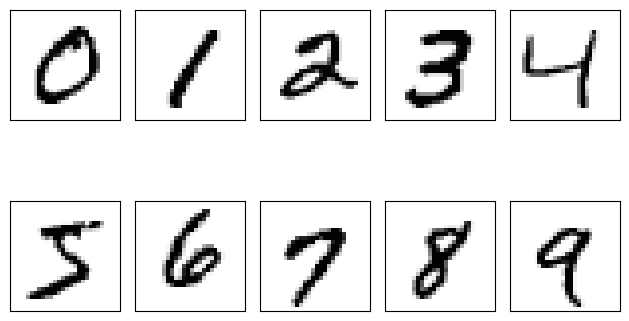

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    # X[y == i]는 (i class인 이미지 개수, 784) size의 배열 반환
    # X[y == i][0]은 그 중 첫 번째 이미지
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

# 눈금 제거
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

여러 사람의 손글씨를 모아놓은 데이터이기 때문에, 손글씨마다 얼마나 차이 나는지 보기 위해 같은 숫자의 샘플을 여러 개 출력해보자

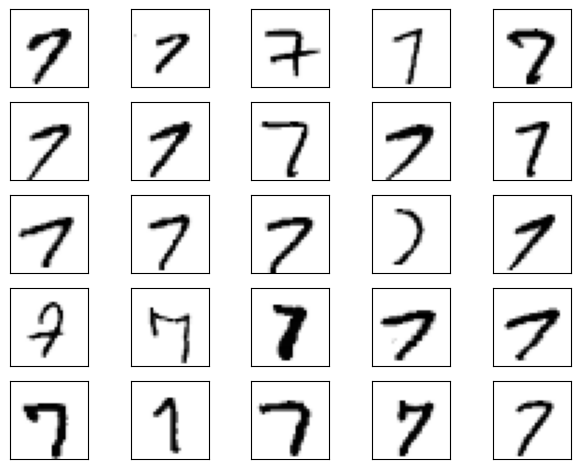

In [31]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    # 7에 해당하는 이미지 25개
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

모델을 학습시키기 위해 불러온 **MNIST 데이터를 Training, Validation, Test data**로 나누어보자. 

Training Data: 55,000개, Validation data: 5,000개, Test data: 10,000개

In [32]:
from sklearn.model_selection import train_test_split

# random_state = 123은 같은 무작위 선택 결과를 위한 seed
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

**2-Layer Neural Network**를 구현해보자

먼저 **Logistic Sigmoid Activatoin function**을 계산하는 함수와 정수 클래스 레이블 배열을 **One-hot enconding**하는 함수를 먼저 구현하자.

In [33]:
import numpy as np
from numpy.typing import NDArray

def sigmoid(z: NDArray[np.float64]) -> NDArray[np.float64]:
    return 1. / (1. + np.exp(-z))

# 전체 데이터 70,000개에 대해 각 행은 one-hot vector로 구성됨
def int_to_onehot(y: NDArray[np.int32], num_labels: int) -> NDArray[np.int32]:
    ary = np.zeros((y.shape[0], num_labels)) # 데이터 개수, label 개수
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

**Multi Layer Perceptron (MLP) Class**를 구현하자

Loss function으로는 **MSE**를 사용하고, Activation function으로는 **Sigmoid function**을 사용한다.

In [34]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # 첫 번째 layer
        # rng: 독립적인 난수 생성기 인스턴스
        # rng 객체로 생성한 난수는 동일한 결과
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(loc = 0.0, scale=0.1, size=(num_hidden, num_features)) # (H, D)
        self.bias_h = np.zeros(num_hidden)

        # 두 번째 Layer
        self.weight_out = rng.normal(loc = 0.0, scale=0.1, size = (num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        # 파트 1: 두 번째 Layer에 대해 Back Propagation
        # MSE 미분
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0] # [num_data, num_classes]
        # sigmoid function 미분
        d_a_out__d_z_out = a_out * (1. - a_out) # [num_data, num_classes]
        
        # d_delta는 재사용을 위한 중간값 저장용 (d_loss__d_z_out)
        d_delta = d_loss__d_a_out * d_a_out__d_z_out # [num_data, num_classes]
        d_z_out__dw_out = a_h # [num_data, num_hidden]

        # [num_classes, num_data] dot [num_data, num_hidden] = [num_calsses, num_data]
        d_loss__dw_out = np.dot(d_delta.T, d_z_out__dw_out)
        # sum([num_data, num_classes]) = [num_classes]
        d_loss__db_out = np.sum(d_delta, axis=0)

        # 파트 2: 첫 번째 Layer에 대한 Back Propagation
        d_z_out__a_h = self.weight_out # [num_classes, num_hidden]

        d_loss__a_h = np.dot(d_delta, d_z_out__a_h) # [num_data, num_hidden] 

        # Sigmoid function 미분
        d_a_h__d_z_h = a_h * (1. - a_h) #[num_data, num_hidden]

        d_z_h__d_w_h = x # [num_data, num_features]

        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h) # [n_hidden, n_features]

        d_loss_d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis = 0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss_d_b_h)

MLP Class를 구현했으니, MLP Class 객체를 생성하자

In [35]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

신경망을 훈련할 수 있는 함수를 구현해보자

**Mini-batch Gradient Descent** 방식으로 진행할 것이므로, 먼저 Mini-batch를 생성하는 함수를 정의해보자

함수 정의 후에는 해당 함수가 정확하게 동작하는지까지 확인한다.

In [36]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # 전체 X.shape[0] 개의 데이터 중, minibatch_size씩 데이터를 분리하기 위함
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        # indices vector에는 random하게 index가 저장되어 있음
        # minibatch_size만큼 Random하게 데이터와 label을 가져옴
        batch_idx = indices[start_idx:start_idx + minibatch_size] 
        
        # yield: return과 비슷하지만, 함수 실행 도중 일시적으로 값을 반환하고, 다음 호출 시 그 자리부터 다시 실행
        # 메모리 절약에 도움이 된다.
        yield X[batch_idx], y[batch_idx]

for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print('X_train_mini:', X_train_mini.shape)
print('y_train_mini:', y_train_mini.shape)

X_train_mini: (100, 784)
y_train_mini: (100,)


**MSE 손실 함수 및 정확도 함수**를 정의하자

In [37]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets-probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

앞의 함수를 테스트하고 이전에 만든 **모델의 Validation data에 대한 MSE와 정확도**를 계산해보자.

10개의 클래스가 **동일한 비율**로 포함되어 있는 데이터셋에서 **무작위 예측의 경우 대부분 10% 정확도**를 갖는다.

왜냐하면 각 클래스가 동일한 비율로 포함되어 있는 경우, 기대되는 정확도는 $\frac{1}{10}$이기 떄문이다.

In [38]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

print(f'Validation set MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Validation set accuracy: {acc*100:.1f}%')

Validation set MSE: 0.3
Validation set accuracy: 9.4%


구현한 모델을 통해서 **예측된 Label 결과를 얻고** 그 결과에 대해 MSE Loss를 구하는 함수와 Accuracy를 구하는 함수를 따로 구현하지 말고, **하나로 구현**해보자.

이 함수에는 Minibatch를 구성하는 것까지 포함된다.

결국 Loss는 mini-batch 내에서 Batch size로 평균내는 것 ($n$으로 나눔) 외에도, 모델 내에 존재하는 $t$개의 활성화 유닛의 평균도 구해야 한다.
$L(w, b) = \frac{1}{n}\sum\frac{1}{t}\sum(y_j^i - a_j^{out[i]})^2$

In [62]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (feature, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(feature) # Mini-batch data에 대해 예측
        predicted_labels = np.argmax(probas, axis = 1)

        # MSE 계산
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets-probas)**2)

        # Accuracy 계산
        correct_pred += (predicted_labels == targets).sum()

        # Mini-batch이기 때문에 전체 데이터에 대한 MSE, Accuracy를 얻기 위해 변수에 더함
        num_examples += targets.shape[0]
        mse += loss

    # mse -> batch 개수로 나눔
    mse = mse/i  

    acc = correct_pred / num_examples

    return mse, acc

mse, acc = compute_mse_and_acc(model, X_valid, y_valid)

print(f'Validation set MSE: {mse:.1f}')

print(f'Validation set accuracy: {acc*100:.1f}%')

Validation set MSE: 0.0
Validation set accuracy: 94.8%


이제 Model을 **Training 시키는 함수**를 구현해보자

In [40]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # Mini_batch를 가져옴
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)
        
        for X_train_mini, y_train_mini in minibatch_gen:
            # Forward
            a_h, a_out = model.forward(X_train_mini)
            
            # Gradient 계산
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            # 가중치 업데이트
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        # Epoch마다 Log을 찍음
        train_mse, train_acc = compute_mse_and_acc (
            model, X_train, y_train
        )

        valid_mse, valid_acc = compute_mse_and_acc (
            model, X_valid, y_valid
        )

        train_acc, valid_acc = train_acc*100, valid_acc*100

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs: 03d}'
              f'| Train MSE: {train_mse:.2f} '
              f'| Train acc: {train_acc:.2f}% '
              f'| Validation acc: {valid_acc:.2f}%')
    return epoch_loss, epoch_train_acc, epoch_valid_acc

Train 함수를 이용하여 **50번의 Epoch 동안** 모델을 훈련시켜 보자. 

In [41]:
np.random.seed(123) # Training dataset shuffle
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/ 50| Train MSE: 0.05 | Train acc: 76.15% | Validation acc: 75.98%
Epoch: 002/ 50| Train MSE: 0.03 | Train acc: 85.45% | Validation acc: 85.04%
Epoch: 003/ 50| Train MSE: 0.02 | Train acc: 87.82% | Validation acc: 87.60%
Epoch: 004/ 50| Train MSE: 0.02 | Train acc: 89.36% | Validation acc: 89.28%
Epoch: 005/ 50| Train MSE: 0.02 | Train acc: 90.21% | Validation acc: 90.04%
Epoch: 006/ 50| Train MSE: 0.02 | Train acc: 90.67% | Validation acc: 90.54%
Epoch: 007/ 50| Train MSE: 0.02 | Train acc: 91.12% | Validation acc: 90.82%
Epoch: 008/ 50| Train MSE: 0.02 | Train acc: 91.43% | Validation acc: 91.26%
Epoch: 009/ 50| Train MSE: 0.01 | Train acc: 91.84% | Validation acc: 91.50%
Epoch: 010/ 50| Train MSE: 0.01 | Train acc: 92.04% | Validation acc: 91.84%
Epoch: 011/ 50| Train MSE: 0.01 | Train acc: 92.30% | Validation acc: 92.08%
Epoch: 012/ 50| Train MSE: 0.01 | Train acc: 92.51% | Validation acc: 92.24%
Epoch: 013/ 50| Train MSE: 0.01 | Train acc: 92.65% | Validation acc: 92.30%

일반적으로 정확도가 낮게 나오는 경우, **Hyperparameter 설정이 이상적이지 않을 가능성이 높다**

신경망을 훈련시키는 것은 다른 모델에 비해 상대적으로 비용이 많이 든다. 
    
따라서 **정확도가 낮게 나오거나 Overfitting이 발생하는 것 같은 경우에는** 실험을 조기에 중단하고 다른 Hyperparameter를 사용

즉, **모델의 성능을 정확하게 평가할 수 있어야한다.**
아래에서는 모델의 성능을 평가하는 방법에 대해 알아보자  

먼저 MSE Loss를 Matpotlib을 이용하여 시각화해보자 

**Epoch가 증가할 수록 Loss가 감소하는 것을 확인할 수 있다.**

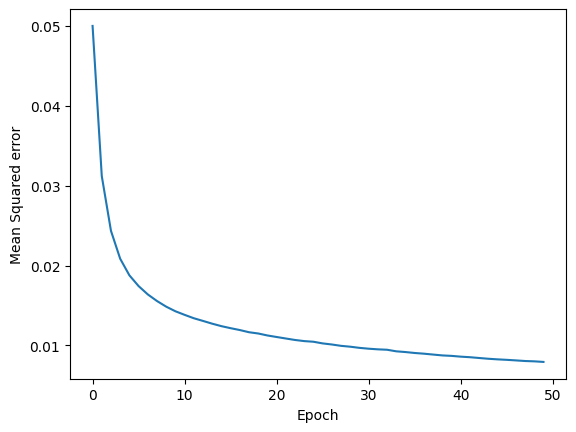

In [49]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean Squared error')
plt.xlabel('Epoch')
plt.show()

Test 정확도와 Validation 정확도도 시각화해보자

**25번째 Epoch까지는 두 정확도 사이의 차이가 없다가 이후로 차이가 커지기 시작한다.**

**25번째 Epoch 이후로 모델이 Training data에 Overfitting 되기 시작함을 의미한다.**

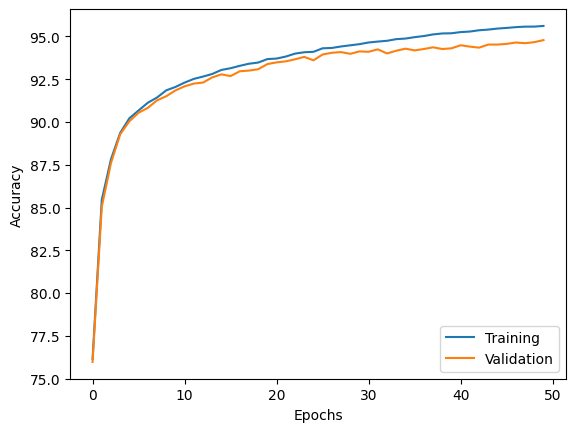

In [54]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

마지막으로 Test Dataset에서 예측 정확도를 계산하여 모델의 일반화 성능을 평가해보자

In [57]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'테스트 정확도: {test_acc*100:.2f}%')

테스트 정확도: 94.54%


여기서 구현한 2-Layer MLP가 어떤 샘플에서 제대로 분류가 되지 않는지 확인하기 위해 Test Dataset에서 **잘못 분류된 처음 25개의 샘플을 확인해보자**

7의 경우 가로줄이 포함된 경우 2로 인식하는 것을 확인할 수 있다. 

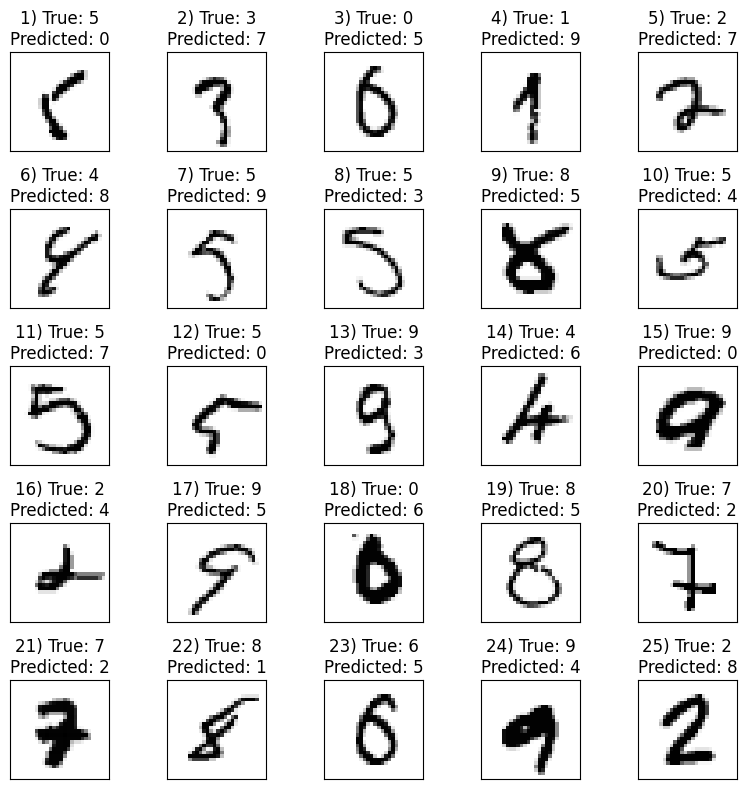

In [61]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]

correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

2-Layer Neural Network 구현은 위에서 끝났다.

책에 나온 내용 중, 새롭거나 중요하다고 생각되는 부분을 아래 정리할 것이다.

___

먼저, Neural Network의 수렴과 관련된 내용이다.

**Online Learning**의 경우, 한 샘플마다 가중치를 수정하였다.
우리가 위 코드에서 사용한 **Mini-batch**는 하나의 샘플이 아니라 여러 샘플마다 가중치를 바꾸는 **Online Learning**의 특별한 경우이다.

위 코드에서 **Mini-batch**를 사용한 이유는 **전체 Training Dataset 중 k개의 우선 벡터화된 구현**을 할 수 있어 
**하나의 샘플마다 가중치를 바꾸는 Online Learning보다 빠르기 때문이다.**
    
하지만 위 방법은 **Loss function이 Wild**한 경우에 **Local Minimum에 갖힐 수 있다.**
이를 극복하기 위한 다양한 최적화 방법들이 존재한다.

가장 간단한 방법은 **Learning rate를 크게 설정**하는 것이다.
- 하지만, Learning rate를 너무 크게 설정하면, **Global minimum을 지나칠 수 있다.**
- 그렇다고 Learning rate를 너무 작게 설정하면 **학습이 오래 걸린다는 단점**이 존재한다.


___
두 번째로, **Back Propagation Algorithm**이 **Neural Network 학습에 가장 널리 사용**되는 이유를 살펴보자 

우선 컴퓨터 프로그램 특히, **Pytorch는 Autograd (자동 미분)을 지원한다.**
- 컴퓨터가 계산 과정에서 **계산 그래프**를 생성하고, **Chain Rule**을 이용하여 자동으로 미분값을 계산하는 방식
- 입력 텐서를 리프 노드로, 출력 텐서를 루트 노드로 가지는 비순환 그래프이다.
- Autograd는 이 그래프를 루트에서 리프까지 추적하여 Chain Rule을 사용해 Gradient를 자동으로 계산한다. 

EX) $y = x² + 2x + 1$

위 식은 다음과 같은 그래프로 나타낼 수 있다.

- **노드(Node)**: $x²$, $2x$, 상수 1, 덧셈 
- **엣지(Edge)**: 노드를 연결하는 데이터의 흐름

자동 미분에는 두 가지 방식이 있다. 
- **정방향**: 입력 -> 출력 순서로 Chain rule 결과를 계산
- **역방향**: 출력 -> 입력 순서로 Chain rule 결과를 계산

**정방향**의 경우, 입력->출력 순서이므로 **입력이 여러 개일 경우, 이미 했던 계산을 또 해야 할 가능성이 있다.**
- 입력이 여러 개인 경우 여러 번 계산해야 해서 사실상 **행렬 × 행렬**처럼 느껴진다.\

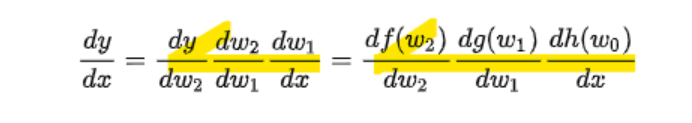
- 이 경우를 보면, $w2$, $w3$에 대한 미분을 계산할 때, $w1$에 대한 미분값을 또 계산해야 한다. 

**역방향**의 경우, 상위 단계에서 사용한 계산에 현재 시점의 Gradient만 곱하면 되므로 **이미 했던 계산을 또 할 필요가 없다.** 
-  출력이 하나인 경우 **벡터 × 행렬** 한 번이면 전체 gradient를 구할 수 있어 빠르다.

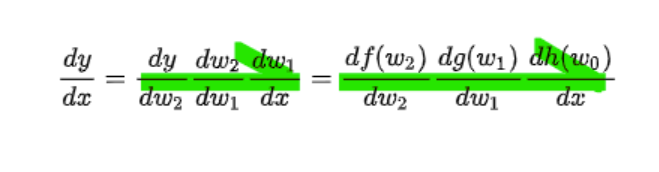
- 이 경우에는 이전 미분값에 그냥 현재 미분값을 곱해주면 된다.

**Back Propagation**의 경우 **역방향 자동 미분**을 사용해서 빠르다.
- Neural Network를 훈련할 때, Back Propagation 알고리즘이 가장 인기 있는 이유이다.

**자동 미분 정리**

**정방향**

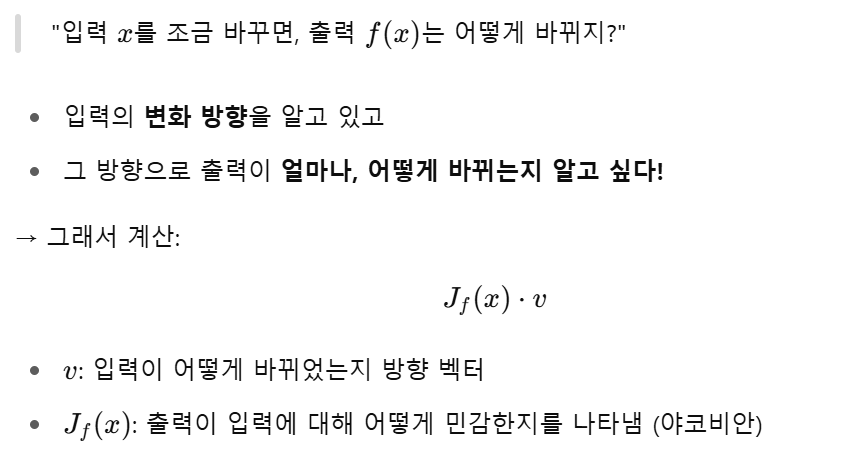


**역방향**

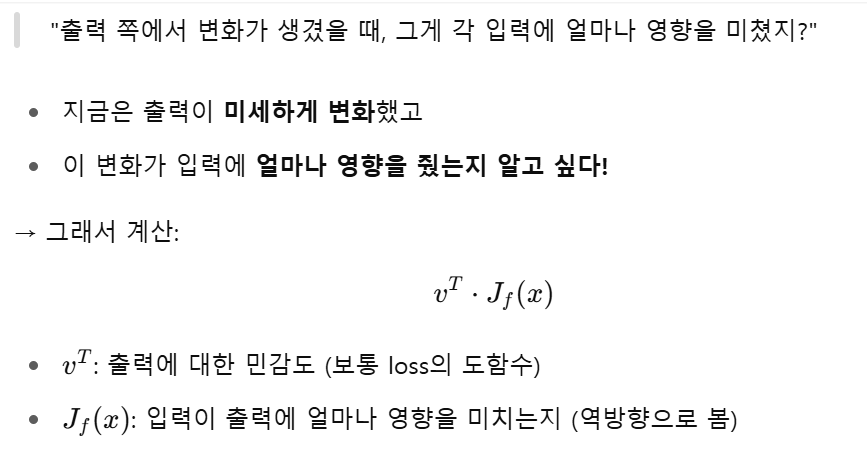